# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyreadr

## Convert data files to csv

### Decathlon

In [2]:
# Load RData file
rdata = pyreadr.read_r("data/decathlon.RData")
rdata

OrderedDict([('X',
                            100m  Long.jump  Shot.put  High.jump   400m  110m.hurdle  \
              rownames                                                                 
              SEBRLE       11.04       7.58     14.83       2.07  49.81        14.69   
              CLAY         10.76       7.40     14.26       1.86  49.37        14.05   
              KARPOV       11.02       7.30     14.77       2.04  48.37        14.09   
              BERNARD      11.02       7.23     14.25       1.92  48.93        14.99   
              YURKOV       11.34       7.09     15.19       2.10  50.42        15.31   
              WARNERS      11.11       7.60     14.31       1.98  48.68        14.23   
              ZSIVOCZKY    11.13       7.30     13.48       2.01  48.62        14.17   
              McMULLEN     10.83       7.31     13.76       2.13  49.91        14.38   
              MARTINEAU    11.64       6.81     14.57       1.95  50.14        14.93   
             

In [3]:
# Access the data frame from the loaded RData file
decathlon = rdata["X"]
decathlon.head()

,100m,Long.jump,Shot.put,High.jump,400m,110m.hurdle,Discus,Pole.vault,Javeline,1500m
rownames,,,,,,,,,,
SEBRLE,11.04,7.58,14.83,2.07,49.81,14.69,43.75,5.02,63.19,291.7
CLAY,10.76,7.40,14.26,1.86,49.37,14.05,50.72,4.92,60.15,301.5
KARPOV,11.02,7.30,14.77,2.04,48.37,14.09,48.95,4.92,50.31,300.2
BERNARD,11.02,7.23,14.25,1.92,48.93,14.99,40.87,5.32,62.77,280.1
YURKOV,11.34,7.09,15.19,2.10,50.42,15.31,46.26,4.72,63.44,276.4


In [4]:
# Convert the data frame to a CSV file
decathlon.to_csv("decathlon.csv", index=True)

### Train and test datafiles

In [5]:
train = {
    f"{letter}": pd.read_csv(
        f"data/train{letter}", delimiter=" ", names=["x1", "x2", "y"]
    )
    for letter in ["A", "B", "C"]
}
train["A"]

,x1,x2,y
0,12.138367,6.455699,1
1,10.622594,11.083096,0
2,11.777052,8.121582,1
3,10.960882,12.226554,0
4,11.296539,10.211002,0
...,...,...,...
95,10.188695,6.171622,1
96,11.024072,4.082187,1
97,11.090619,10.954867,0
98,9.840793,4.902898,1


In [6]:
test = {
    f"{letter}": pd.read_csv(
        f"data/test{letter}", delimiter=" ", names=["x1", "x2", "y"]
    )
    for letter in ["A", "B", "C"]
}
test["A"]

,x1,x2,y
0,12.356261,6.053231,1
1,11.842674,4.832690,1
2,12.080976,5.739803,1
3,9.435296,8.878012,0
4,11.023415,6.173500,1
...,...,...,...
95,12.132122,10.539799,0
96,10.948403,6.676466,1
97,8.728051,5.950333,1
98,9.376795,9.968496,0


# 1. Classification

## 1.1 Analyse linéaire discriminante

### a- Ecrire l'estimateur du maximum de vraisemblance des paramètres du modèle

$$\begin{align}

L_{(x_i, y_i)_i}(\pi, \mu_0, \mu_1, \Sigma) 
    & = log \hspace{8px} p(x_1,..., x_n, y_1,...y_n | \pi, \mu_0, \mu_1, \Sigma) \\
    & = \sum_{i=1}^n log \hspace{8px} p(x_i, y_i | \pi, \mu_0, \mu_1, \Sigma) \\
    & = \sum_{i=1}^n log \hspace{8px} p(x_i | y_i, \mu_0, \mu_1, \Sigma) * p(y_i | \pi) \\
    & = \sum_{i=1}^n log \hspace{8px} p(x_i | y_i, \mu_0, \mu_1, \Sigma) + \sum_{i=1}^n log \hspace{8px} p(y_i | \pi)
\end{align}$$

On remarque qu'en dérivant par rapport à $\pi$ dans (4), on perdra la somme de gauche.  
De même, en dérivant par rapport à $\mu_0, \mu_1$ ou $\Sigma$, on perdra la somme de droite.  
On va donc calculer $\hat{\pi}_{EMV}$ et $\hat{\mu_0}_{EMV}$, $\hat{\mu_1}_{EMV}$, $\hat{\Sigma}_{EMV}$ à part.

**Commençons par calculer $\hat{\pi}_{EMV}$**   

$$\begin{align*}

L_{(y_i)_i}(\pi) & = log \hspace{8px} p(y_1,...y_n | \pi) \\
    & = \sum_{i=1}^n log \hspace{8px} p(y_i | \pi) \\
    & = \sum_{i=1}^n log \hspace{8px} \pi^{y_i} \cdot (1-\pi)^{1-y_i} \\
    & = \sum_{i=1}^n y_i \cdot log(\pi) + (1-y_i) \cdot log(1-\pi) \\ 

\end{align*}$$

Dérivons cette quantité par rapport à $\pi$

$$\begin{align*}

\nabla_\pi(L_{(y_i)_i}(\pi)) & = \sum_{i=1}^n \frac{y_i}{\pi} - \frac{1}{1-\pi} + \frac{y_i}{1-\pi} \\
    & = - \frac{n}{1-\pi} + \sum_{i=1}^n \frac{y_i}{\pi(1-\pi)}
    
\end{align*}$$

Maximiser la vraisemblance revient à maximiser la log-vraisemblance par croissance de la fonction logarithme sur $[0, 1]$, l'ensemble de définition de $\pi$.  
Déterminons la valeur de $\pi$ qui maximise la log-vraisemblance.  

Soit $\pi \in [0, 1] / \nabla_\pi(L_{(y_i)_i}(\pi)) = 0$,
alors on a
$$ \sum_{i=1}^n \frac{y_i}{\pi(1-\pi)} = \frac{n}{1-\pi} $$
i.e.
$$ \pi = \frac{1}{n} \sum_{i=1}^{n} y_i = \bar{y}$$

Donc $\boxed{\hat{\pi}_{EMV} = \bar{y}}$ 


**A présent, calculons $\hat{\mu_0}, \hat{\mu_1}$ et $\hat{\Sigma}$**

$$\begin{align*}

L_{(x_i)_i}(y_i, \mu_0, \mu_1, \Sigma)
    & = log \hspace{8px} p(x_1,...x_n | y_1,...,y_n, \mu_0, \mu_1, \Sigma) \\
    & = \sum_{i=1}^n log \hspace{8px} p(x_i | y_i, \mu_0, \mu_1, \Sigma) \\
    & = \begin{align*}
        \sum_{i=1}^n
            & \mathbb{1}_{y_i = 0} \cdot log \hspace{8px} \frac{1}{\sqrt{2\pi^{2}|\Sigma|}} \cdot \exp^{-\frac{1}{2} (x_i - \mu_0)^T \Sigma^{-1} (x_i - \mu_0)} \\
            & \mathbb{1}_{y_i = 1} \cdot log \hspace{8px} \frac{1}{\sqrt{2\pi^{2}|\Sigma|}} \cdot \exp^{-\frac{1}{2} (x_i - \mu_1)^T \Sigma^{-1} (x_i - \mu_1)} \\
        \end{align*}
        \\
    & = \begin{align*}
        \sum_{i=1}^n
            & \mathbb{1}_{y_i = 0} \cdot [ \frac{1}{2} \cdot log(2\pi^{2}|\Sigma|) - \frac{1}{2}
            \cdot (x_i - \mu_0)^T \Sigma^{-1} (x_i - \mu_0) ] \\
            & \mathbb{1}_{y_i = 1} \cdot [ \frac{1}{2} \cdot log(2\pi^{2}|\Sigma|) - \frac{1}{2}
            \cdot (x_i - \mu_1)^T \Sigma^{-1} (x_i - \mu_1) ]
        \end{align*}

\end{align*}$$

On peut calculer, à partir de cette forme, le gradient de la log vraisemblance par rapport à $\mu_0$.

$$
\nabla_{\mu_0}(L_{(x_i)_i}(y_i, \mu_0, \mu_1, \Sigma))
    = - \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} \cdot \Sigma^{-1} \cdot (x_i - \mu_0)
$$
Et alors, on peut maximiser la log vraisemblance.  
Soit $\mu_0 \in \mathbb{R}^2 / \nabla_{\mu_0}(L_{(x_i)_i}(y_i, \mu_0, \mu_1, \Sigma)) = 0_2$, on a alors
$$
- \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} \cdot ( \Sigma^{-1} \cdot x_i - \Sigma^{-1} \cdot \mu_0 ) = 0
$$
Introduisons les notations $n_0 = card\{i \in [1;n] / y_i = 0\}$, le nombre d'individus dans la classe 0,  
et $\bar{x_0} = \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} \cdot x_i$, la moyenne des individus de la classe 0.  

On a alors
$$ n_0 \cdot \Sigma^{-1} \mu_0 = \Sigma^{-1} \cdot \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} \cdot x_i
$$
Et donc
$$\boxed{\mu_0 = \hat{\mu_0} = \frac{\bar{x_0}}{n_0}}
$$


De la même façon, on calcule $\boxed{\displaystyle \hat{\mu_1} = \frac{\bar{x_1}}{n_1}}$

**Calcul de $\hat{\Sigma}$ :**  
On sait que $\displaystyle \hat{\Sigma_{EMV}} = \sum_{i=1}^{n} (x_i - \hat{\mu_{EMV}}) \cdot (x_i - \hat{\mu_{EMV}})^T$ pour un vecteur aléatoire gaussien.

Dans notre cas à deux classes,
$$\hat{\Sigma_{EMV}} = 
    \frac{
        \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} (x_i - \hat{\mu_0}) \cdot (x_i - \hat{\mu_0})^T
        + \sum_{i=1}^{n} \mathbb{1}_{y_i = 1} (x_i - \hat{\mu_1}) \cdot (x_i - \hat{\mu_1})^T
        }{
            n
        }
$$

**Justification :**  
En réutilisant la preuve du cours,  
$$
\begin{align*}
\nabla_{\Sigma}(L_{(x_i)_i}(y_i, \mu_0, \mu_1, \Sigma))
    =
    &- \frac{n_0}{2}\Sigma^{-1}
    + \frac{1}{2}\Sigma^{-1} \cdot \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} (x_i - \mu_0) \cdot (x_i - \mu_0)^T \cdot \Sigma^{-1} \\
    &-
    \frac{n_1}{2}\Sigma^{-1}
    + \frac{1}{2}\Sigma^{-1} \cdot \sum_{i=1}^{n} \mathbb{1}_{y_i = 1} (x_i - \mu_1) \cdot (x_i - \mu_1)^T \cdot \Sigma^{-1}
\end{align*}
$$
On peut alors maximiser la vraisemblance :  

$\nabla_{\Sigma}(L_{(x_i)_i}(y_i, \mu_0, \mu_1, \Sigma)) = 0_{(2,2)}$

$$\Leftrightarrow
\begin{align*}
0   =
    &- \frac{n_0}{2}\Sigma + \frac{1}{2} \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} (x_i - \mu_0) \cdot (x_i - \mu_0)^T \\
    &-
    \frac{n_1}{2}\Sigma + \frac{1}{2} \sum_{i=1}^{n} \mathbb{1}_{y_i = 1} (x_i - \mu_1) \cdot (x_i - \mu_1)^T
\end{align*}
$$

$$\Leftrightarrow
0 = -\frac{n_0 + n_1}{2} \cdot \Sigma + \frac{1}{2}
    \cdot \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} \cdot (x_i - \mu_0) \cdot (x_i - \mu_0)^T
    + \mathbb{1}_{y_i = 1} (x_i - \mu_1) \cdot (x_i - \mu_1)^T
$$

$$\Leftrightarrow
\boxed{
\Sigma =
\frac{
        \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} \cdot (x_i - \mu_0) \cdot (x_i - \mu_0)^T
        + \mathbb{1}_{y_i = 1} (x_i - \mu_1) \cdot (x_i - \mu_1)^T
    }{
        n_0 + n_1
    }
}
$$


### b- Donner la probabilité conditionnelle $P(Y=1|X=x)$. Comparer avec la même quantité dans le cadre de la régression logistique

On rappel que l'on note $p(x|\theta)$ la fonction de densité de la loi marginale de $X$ de paramètre $\theta$ évaluée en $x$.
$$\begin{align}
P(Y=1 | X=x)
    &= \frac{p(x | y=1, \theta) \cdot p(y=1|\pi)}{p(x | \theta)} \\
    &= \frac{\mathcal{N}(x ; \mu_1, \Sigma) \cdot \pi}{p(x | \theta)} \\
\end{align}
$$
Par renversement du conditionnement avec la formule de Bayes.  

On peut calculer la loi marginale de $X$ au dénominateur :
$$
\begin{align*}
p(x | \theta)
    =& \mathcal{N}(x ; \mu_0, \Sigma) \cdot p(y=0|\pi) + \mathcal{N}(x ; \mu_1, \Sigma) \cdot p(y=1|\pi) \\
    =& \frac{1}{\sqrt{2\pi^{2}|\Sigma|}} \cdot e^{-\frac{1}{2} (x - \mu_0)^T \Sigma^{-1} (x - \mu_0)} \cdot (1-\pi)
    + \frac{1}{\sqrt{2\pi^{2}|\Sigma|}} \cdot e^{-\frac{1}{2} (x - \mu_1)^T \Sigma^{-1} (x - \mu_1)} \cdot \pi
\end{align*}
$$
$X$ est un mélange de gaussiennes de même matrices de variances covariances et de moyennes différentes.

Développons la formule.

$$\begin{align*}
P(Y=1 | X=x)
    &= \frac{
        \mathcal{N}(x ; \mu_1, \Sigma) \cdot \pi
    }{
        \mathcal{N}(x ; \mu_0, \Sigma) \cdot (1-\pi) + \mathcal{N}(x ; \mu_1, \Sigma) \cdot \pi
    } \\
    &= \frac{1}{
        1 + \frac{
            \mathcal{N}(x ; \mu_0, \Sigma) \cdot (1-\pi)
        }{
            \mathcal{N}(x ; \mu_1, \Sigma) \cdot \pi
        }
    } \hspace{10px} \text{en factorisant par $\mathcal{N}(x ; \mu_1, \Sigma) \cdot \pi$ et en supposant que $\pi \ne 0$} \\
    &= \frac{1}{
        1 + \frac{1-\pi}{\pi} \cdot
        \exp[\frac{1}{2}(
                    (x-\mu_0)^T \Sigma^{-1} (x-\mu_0)
                ) - (
                    (x-\mu_1)^T \Sigma^{-1} (x-\mu_1)
                )]
    }
\end{align*}
$$

**Dans le cas $\pi = \frac{1}{2}$, on peut se ramener à la régression logistique :**

$$\begin{align*}
P(Y=1 | X=x)
    &= \frac{1}{
        1 + \exp[\frac{1}{2}(
                    (x-\mu_0)^T \Sigma^{-1} (x-\mu_0)
                ) - (
                    (x-\mu_1)^T \Sigma^{-1} (x-\mu_1)
                )]
    } \\
    &= \frac{1}{
        1 + \exp(
                x^T \Sigma^{-1} \mu_1 - x^T \Sigma^{-1} \mu_0
                + \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0 - \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1
        )} \\
    &= \frac{1}{
        1 + \exp(
                x^T \Sigma^{-1} (\mu_1 - \mu_0)
                + \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0 - \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1
        )} \\
    &= \frac{1}{
        1 + \exp(
                x^T \beta
                + \beta_0
        )}
\end{align*}
$$
En notant $\beta = \Sigma^{-1} (\mu_1 - \mu_0)$ et $\beta_0 = \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0 - \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1$  

Pour une valeur de $\pi \in [0 ; 1]$ quelconque, on remarque que l'on a un critère de classification plus riche que la régression logistique.  
En effet, l'analyse linéaire discriminante prend en compte les poids associés aux classes :

$$ P(Y=1 | X=x) = \frac{1}{1 + \frac{1 - \pi}{\pi} \exp(x^T \beta + \beta_0)} $$

### c- Implémenter l’EMV pour ce modèle
Appliquer l’EMV aux données. Représenter graphiquement les données sous la forme d’un nuage de points dans $\mathbb{R}^2$ ainsi que la fonction définie pour x∈R2 par l’équation $P(Y=1|X=x)=1/2$

#### Définitions de fonctions

In [7]:
def calc_pi_mle(dataset: pd.DataFrame) -> float:
    """Calculate maximum likelihood estimator for pi

    Args:
        dataset (pd.DataFrame): Dataset containing a binary class column named "y"

    Returns:
        float: Maximum likelihood for pi
    """

    y = dataset.loc[:, "y"]
    pi_mle = sum(y) / len(y)

    return pi_mle

In [8]:
def calc_mu_mle(dataset: pd.DataFrame) -> tuple:
    """Calculate maximum likelihood estimator for mu_0 and mu_1

    Args:
        dataset (pd.DataFrame): Two dimensional dataset ("x1", "x2") with a binary class column "y"

    Returns:
        tuple: (mu0_mle, mu1_mle)
    """

    # Split dataset based on class
    class0 = dataset[dataset["y"] == 0]
    class1 = dataset[dataset["y"] == 1]

    # Calculate mu0_mle and mu1_mle
    mu0_mle = class0.loc[:, ["x1", "x2"]].sum() / len(class0)
    mu1_mle = class1.loc[:, ["x1", "x2"]].sum() / len(class1)

    # Convert as numpy array
    mu0_mle = np.array(mu0_mle)
    mu1_mle = np.array(mu1_mle)

    return (mu0_mle, mu1_mle)

In [9]:
def calc_sigma_mle(dataset: pd.DataFrame, mu0_mle: float, mu1_mle: float) -> np.ndarray:
    """Calculate maximum likelihood for variance covariance matrix

    Args:
        dataset (pd.DataFrame): Two dimensional dataset ("x1", "x2") with a binary class column "y"
        mu0_mle (float): MLE for mu0
        mu1_mle (float): MLE for mu1

    Returns:
        np.ndarray: MLE for sigma of shape (2, 2)
    """
    # Split dataset based on class
    class0 = dataset[dataset["y"] == 0]
    class1 = dataset[dataset["y"] == 1]

    # Transform into numpy array for easier computation
    class0 = np.array(class0[["x1", "x2"]])
    class1 = np.array(class1[["x1", "x2"]])

    sum_over_class1 = (class0 - mu0_mle).T @ (
        class0 - mu0_mle
    )  # (2, 52) * (52, 2) = (2, 2)
    # (52, 2) - (2,) substract the (2,) vector
    # element wise to each row of the (52, 2) matrix in numpy
    sum_over_class2 = (class1 - mu1_mle).T @ (class1 - mu1_mle)

    sigma_mle = (sum_over_class1 + sum_over_class2) / len(
        dataset
    )  # len(dataset) = n_0 + n_1 = n

    return sigma_mle

#### Calculs des EMV

In [14]:
# Apply MLE to train data


dataset = train["A"]

pi_mle = calc_pi_mle(dataset)
mu0_mle, mu1_mle = calc_mu_mle(dataset)
sigma_mle = calc_sigma_mle(dataset, mu0_mle=mu0_mle, mu1_mle=mu1_mle)

#### Tracé du nuage de points et de la frontière de décision

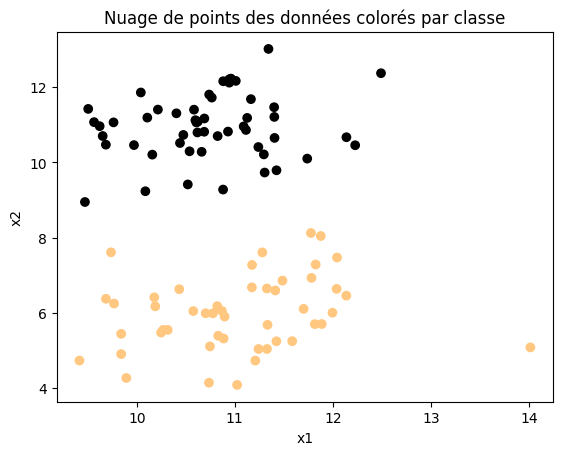

In [50]:
plt.scatter(
    dataset.loc[:, "x1"], dataset.loc[:, "x2"], c=dataset.loc[:, "y"], cmap="copper"
)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Nuage de points des données colorés par classe")
plt.show()

$$ P(Y=1|X=x) = \frac{1}{2}
$$

$$\Leftrightarrow
\frac{1}{
        1 + \frac{1-\pi}{\pi} \cdot
        \exp[x^T \Sigma^{-1} (\mu_1 - \mu_0)
            + \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0 - \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1]
    } = \frac{1}{2}
$$

$$ \Leftrightarrow
\frac{1-\pi}{\pi} \cdot
\exp[x^T \Sigma^{-1} (\mu_1 - \mu_0)
    + \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0 - \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1
    ]
= 1
$$

$$ \Leftrightarrow
\exp[x^T \Sigma^{-1} (\mu_1 - \mu_0)
    + \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0 - \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1
    ]
= \frac{\pi}{1-\pi} \hspace{8px} \text{en supposant que $\pi \ne 1$}
$$

$$ \Leftrightarrow
x^T \Sigma^{-1} (\mu_1 - \mu_0)
+ \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0 - \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1
= \ln(\frac{\pi}{1-\pi}) \hspace{8px} \text{car $\frac{\pi}{1-\pi} > 0$}
$$

$$ \Leftrightarrow
x^T \Sigma^{-1} (\mu_1 - \mu_0)
=   - \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0
    + \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1
    + \ln(\frac{\pi}{1-\pi})
$$

Notons $x^T = (x_1, x_2)$ et $\mu_1 - \mu_0 = \lambda = (\lambda_1, \lambda_2)$  
Alors 
$$ x^T \Sigma^{-1} (\mu_1 - \mu_0)
    = x_1 \cdot (\Sigma^{-1}_{1,1} \lambda_1 + \Sigma^{-1}_{1,2} \lambda_2)
    + x_2 \cdot (\Sigma^{-1}_{2,1} \lambda_1 + \Sigma^{-1}_{2,2} \lambda_2)
$$

Avec cette forme développée, nous pouvons expliciter la formule de la droite d'équation
$P(Y=1|X=x) = \frac{1}{2}$

$$\Leftrightarrow

x_1 = \frac{
        - \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0
        + \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1
        + \ln(\frac{\pi}{1-\pi})
        - x_2 \cdot (\Sigma^{-1}_{2,1} \lambda_1 + \Sigma^{-1}_{2,2} \lambda_2)
}{
    \Sigma^{-1}_{1,1} \lambda_1 + \Sigma^{-1}_{1,2} \lambda_2
}
$$

On peut désormais calculer l'équation de la droite de séparation de façon explicite, sans avoir à faire de *meshgrid* sur notre espace de données.

In [40]:
# Calculate inverse of sigma_mle
sigma_mle_inv = np.linalg.inv(sigma_mle)

# Define lambda_ as above
lambda_ = mu1_mle - mu0_mle

In [67]:
# Make a sample vector for x2
xx2 = np.linspace(4, 14, 100)

# Calculate upper part of the fraction above
numerateur = (
    (-1 / 2) * (mu0_mle @ sigma_mle_inv @ mu0_mle.T)
    + (1 / 2) * (mu1_mle @ sigma_mle_inv @ mu1_mle.T)
    + np.log(pi_mle / (1 - pi_mle))
    - xx2 * (sigma_mle_inv[1, 0] * lambda_[0] + sigma_mle_inv[1, 1] * lambda_[1])
)

# Calculate lower part of the fraction above
denominateur = sigma_mle_inv[0, 0] * lambda_[0] + sigma_mle_inv[0, 1] * lambda_[1]

# Calculate f(xx2), the border of decision
f_xx2 = numerateur / denominateur

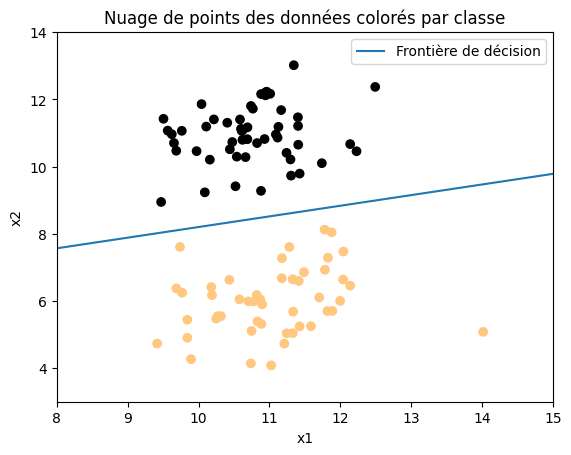

In [68]:
plt.scatter(
    dataset.loc[:, "x1"], dataset.loc[:, "x2"], c=dataset.loc[:, "y"], cmap="copper"
)
plt.plot(f_xx2, xx2, label="Frontière de décision")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Nuage de points des données colorés par classe")
plt.legend()
plt.ylim([3, 14])
plt.xlim([8, 15])
plt.show()